In [1]:
import pandas as pd

# ---------- Paths ----------
TX_PATH = 'TX_NODE1.csv'
RX_PATH = 'RX_NODE1.csv'

# ---------- Load ----------
df_tx = pd.read_csv(TX_PATH)
df_rx = pd.read_csv(RX_PATH)

# Normalize column names just in case
df_tx.columns = [c.strip().lower() for c in df_tx.columns]
df_rx.columns = [c.strip().lower() for c in df_rx.columns]

# Expected columns: time_ms, packet_type, sequence_no, fragment_idx, total_fragments, packet_size_bytes
needed_cols = ["time_ms", "packet_type", "sequence_no", "fragment_idx", "total_fragments"]
for name, df in [("TX", df_tx), ("RX", df_rx)]:
    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name} CSV missing columns: {missing}")

# Ensure numeric types where appropriate
for df in (df_tx, df_rx):
    df["time_ms"] = pd.to_numeric(df["time_ms"], errors="coerce")
    df["sequence_no"] = pd.to_numeric(df["sequence_no"], errors="coerce")
    df["fragment_idx"] = pd.to_numeric(df["fragment_idx"], errors="coerce")
    df["total_fragments"] = pd.to_numeric(df["total_fragments"], errors="coerce")
    df.dropna(subset=["time_ms", "sequence_no"], inplace=True)


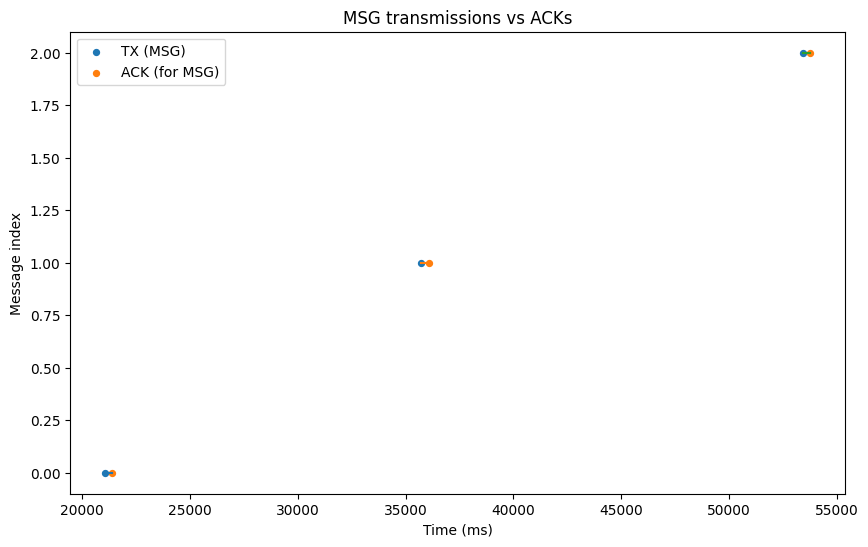

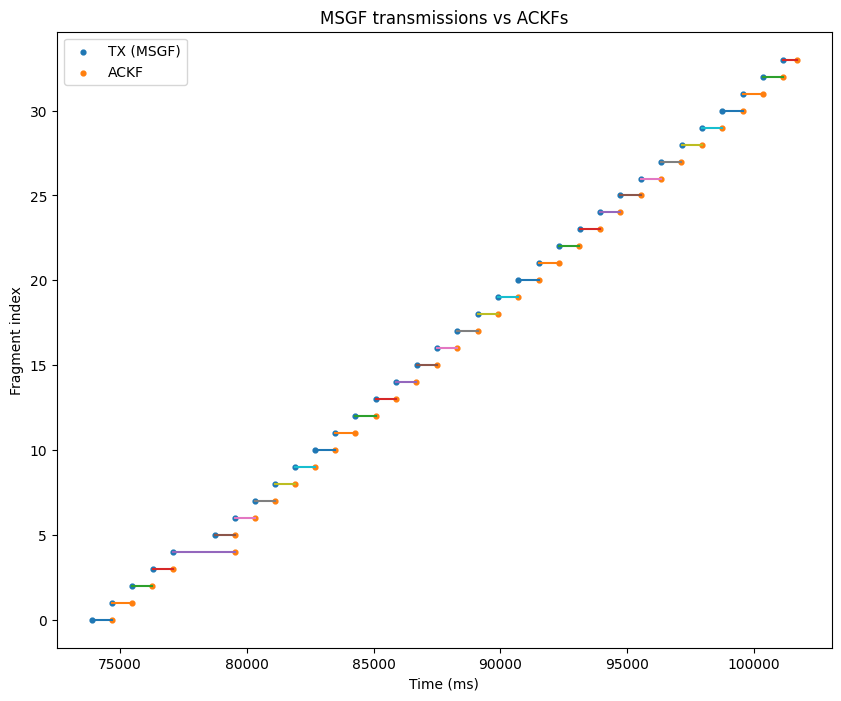

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Build Pairs (MSG ↔ ACK) ----------
tx_msg = df_tx[df_tx["packet_type"].str.upper() == "MSG"].copy()
rx_ack = df_rx[df_rx["packet_type"].str.upper() == "ACK"].copy()

pairs_msg = pd.merge(
    tx_msg[["time_ms", "sequence_no"]].rename(columns={"time_ms": "tx_time_ms"}),
    rx_ack[["time_ms", "sequence_no"]].rename(columns={"time_ms": "ack_time_ms"}),
    on="sequence_no",
    how="left"
)

pairs_msg["rtt_ms"] = pairs_msg["ack_time_ms"] - pairs_msg["tx_time_ms"]

# ---------- Build Pairs (MSGF ↔ ACKF) ----------
tx_frag = df_tx[df_tx["packet_type"].str.upper() == "MSGF"].copy()
rx_ackf = df_rx[df_rx["packet_type"].str.upper() == "ACKF"].copy()

pairs_frag = pd.merge(
    tx_frag[["time_ms", "sequence_no", "fragment_idx"]].rename(columns={"time_ms": "tx_time_ms"}),
    rx_ackf[["time_ms", "sequence_no", "fragment_idx"]].rename(columns={"time_ms": "ack_time_ms"}),
    on=["sequence_no", "fragment_idx"],
    how="left"
)

pairs_frag["rtt_ms"] = pairs_frag["ack_time_ms"] - pairs_frag["tx_time_ms"]

# ---------- Plot MSG packets ----------
msg_plot = pairs_msg.sort_values("sequence_no").reset_index(drop=True)
if not msg_plot.empty:
    y_vals = np.arange(len(msg_plot))
    plt.figure(figsize=(10, 6))
    plt.scatter(msg_plot["tx_time_ms"], y_vals, label="TX (MSG)", s=18)
    plt.scatter(msg_plot["ack_time_ms"], y_vals, label="ACK (for MSG)", s=18)
    for i, row in msg_plot.iterrows():
        if not np.isnan(row["ack_time_ms"]):
            plt.plot([row["tx_time_ms"], row["ack_time_ms"]], [y_vals[i], y_vals[i]])
    plt.xlabel("Time (ms)")
    plt.ylabel("Message index")
    plt.title("MSG transmissions vs ACKs")
    plt.legend()
    plt.show()

# ---------- Plot MSGF fragments ----------
frag_plot = pairs_frag.sort_values(["sequence_no", "fragment_idx"]).reset_index(drop=True)
if not frag_plot.empty:
    frag_plot["y"] = np.arange(len(frag_plot))
    plt.figure(figsize=(10, 8))
    plt.scatter(frag_plot["tx_time_ms"], frag_plot["y"], label="TX (MSGF)", s=12)
    plt.scatter(frag_plot["ack_time_ms"], frag_plot["y"], label="ACKF", s=12)
    for i, row in frag_plot.iterrows():
        if not np.isnan(row["ack_time_ms"]):
            plt.plot([row["tx_time_ms"], row["ack_time_ms"]], [row["y"], row["y"]])
    plt.xlabel("Time (ms)")
    plt.ylabel("Fragment index")
    plt.title("MSGF transmissions vs ACKFs")
    plt.legend()
    plt.show()


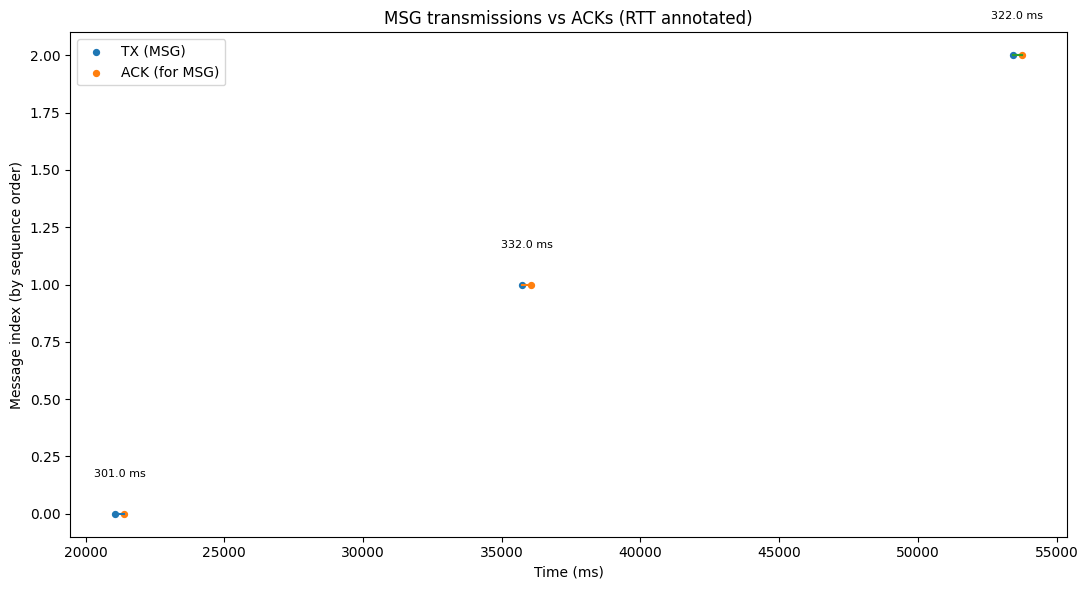

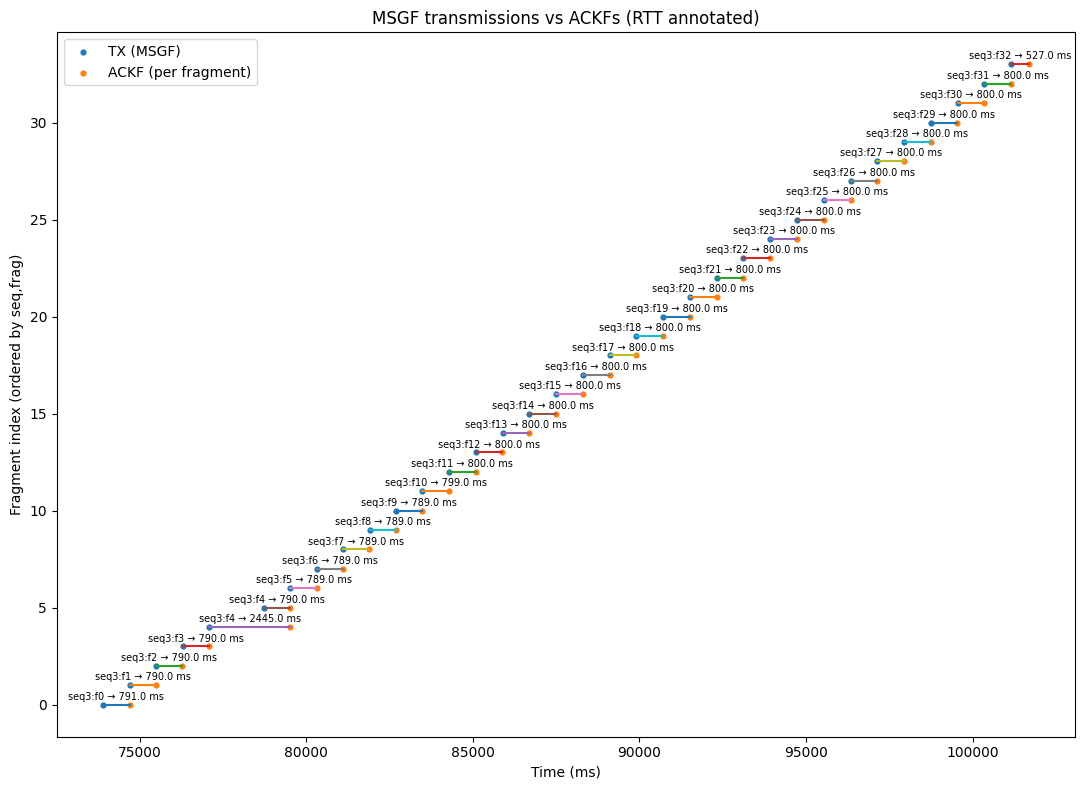

TX→ACK Pairs with RTT (annotated)


,kind,sequence_no,tx_time_ms,ack_time_ms,rtt_ms,fragment_idx
0,MSG,0,21075,21376,301,NaN
1,MSG,1,35732,36064,332,NaN
2,MSG,2,53416,53738,322,NaN
3,MSGF,3,73898,74689,791,0.0
4,MSGF,3,74692,75482,790,1.0
5,MSGF,3,75485,76275,790,2.0
6,MSGF,3,76280,77070,790,3.0
7,MSGF,3,77073,79518,2445,4.0
8,MSGF,3,78728,79518,790,4.0
9,MSGF,3,79521,80310,789,5.0


Saved: tx_ack_pairs_annotated.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Paths ----------
TX_PATH = 'TX_NODE1.csv'
RX_PATH = 'RX_NODE1.csv'

# ---------- Load ----------
df_tx = pd.read_csv(TX_PATH)
df_rx = pd.read_csv(RX_PATH)

# Normalize column names just in case
df_tx.columns = [c.strip().lower() for c in df_tx.columns]
df_rx.columns = [c.strip().lower() for c in df_rx.columns]

# Ensure numeric types where appropriate
for df in (df_tx, df_rx):
    df["time_ms"] = pd.to_numeric(df["time_ms"], errors="coerce")
    df["sequence_no"] = pd.to_numeric(df["sequence_no"], errors="coerce")
    if "fragment_idx" in df.columns:
        df["fragment_idx"] = pd.to_numeric(df["fragment_idx"], errors="coerce")
    if "total_fragments" in df.columns:
        df["total_fragments"] = pd.to_numeric(df["total_fragments"], errors="coerce")
    df.dropna(subset=["time_ms", "sequence_no"], inplace=True)

# ---------- Build Pairs (MSG ↔ ACK) ----------
tx_msg = df_tx[df_tx["packet_type"].str.upper() == "MSG"].copy()
rx_ack = df_rx[df_rx["packet_type"].str.upper() == "ACK"].copy()

pairs_msg = pd.merge(
    tx_msg[["time_ms", "sequence_no"]].rename(columns={"time_ms": "tx_time_ms"}),
    rx_ack[["time_ms", "sequence_no"]].rename(columns={"time_ms": "ack_time_ms"}),
    on="sequence_no",
    how="left"
)
pairs_msg["rtt_ms"] = pairs_msg["ack_time_ms"] - pairs_msg["tx_time_ms"]
pairs_msg = pairs_msg.sort_values("sequence_no").reset_index(drop=True)

# ---------- Plot MSG packets with RTT annotations ----------
if not pairs_msg.empty:
    y_vals = np.arange(len(pairs_msg))
    plt.figure(figsize=(11, 6))
    plt.scatter(pairs_msg["tx_time_ms"], y_vals, label="TX (MSG)", s=18)
    plt.scatter(pairs_msg["ack_time_ms"], y_vals, label="ACK (for MSG)", s=18)
    for i, row in pairs_msg.iterrows():
        tx = row["tx_time_ms"]
        ack = row["ack_time_ms"]
        if not np.isnan(ack):
            plt.plot([tx, ack], [y_vals[i], y_vals[i]])
            midx = (tx + ack) / 2.0
            plt.text(midx, y_vals[i] + 0.15, f"{row['rtt_ms']:.1f} ms",
                     fontsize=8, ha="center", va="bottom")
    plt.xlabel("Time (ms)")
    plt.ylabel("Message index (by sequence order)")
    plt.title("MSG transmissions vs ACKs (RTT annotated)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Build Pairs (MSGF ↔ ACKF) per fragment ----------
tx_frag = df_tx[df_tx["packet_type"].str.upper() == "MSGF"].copy()
rx_ackf = df_rx[df_rx["packet_type"].str.upper() == "ACKF"].copy()

pairs_frag = pd.merge(
    tx_frag[["time_ms", "sequence_no", "fragment_idx"]].rename(columns={"time_ms": "tx_time_ms"}),
    rx_ackf[["time_ms", "sequence_no", "fragment_idx"]].rename(columns={"time_ms": "ack_time_ms"}),
    on=["sequence_no", "fragment_idx"],
    how="left"
)
pairs_frag["rtt_ms"] = pairs_frag["ack_time_ms"] - pairs_frag["tx_time_ms"]
pairs_frag = pairs_frag.sort_values(["sequence_no", "fragment_idx"]).reset_index(drop=True)

# ---------- Plot MSGF fragments with RTT annotations ----------
if not pairs_frag.empty:
    y_frag = np.arange(len(pairs_frag))
    plt.figure(figsize=(11, 8))
    plt.scatter(pairs_frag["tx_time_ms"], y_frag, label="TX (MSGF)", s=12)
    plt.scatter(pairs_frag["ack_time_ms"], y_frag, label="ACKF (per fragment)", s=12)
    for i, row in pairs_frag.iterrows():
        tx = row["tx_time_ms"]
        ack = row["ack_time_ms"]
        if not np.isnan(ack):
            plt.plot([tx, ack], [y_frag[i], y_frag[i]])
            midx = (tx + ack) / 2.0
            seq = int(row["sequence_no"]) if not np.isnan(row["sequence_no"]) else -1
            frag = int(row["fragment_idx"]) if not np.isnan(row["fragment_idx"]) else -1
            plt.text(midx, y_frag[i] + 0.15, f"seq{seq}:f{frag} → {row['rtt_ms']:.1f} ms",
                     fontsize=7, ha="center", va="bottom")
    plt.xlabel("Time (ms)")
    plt.ylabel("Fragment index (ordered by seq,frag)")
    plt.title("MSGF transmissions vs ACKFs (RTT annotated)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Export combined table ----------
pairs_all_export = pd.concat([
    pairs_msg.assign(kind="MSG")[["kind","sequence_no","tx_time_ms","ack_time_ms","rtt_ms"]],
    pairs_frag.assign(kind="MSGF")[["kind","sequence_no","fragment_idx","tx_time_ms","ack_time_ms","rtt_ms"]]
], ignore_index=True)

print("TX→ACK Pairs with RTT (annotated)")
display(pairs_all_export)
pairs_all_export.to_csv("tx_ack_pairs_annotated.csv", index=False)
print("Saved: tx_ack_pairs_annotated.csv")